In [1]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [26]:
df = loader()

In [3]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [25]:
# With help and inspiration from 
# https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import nan, nanmean, isnan
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], timesteps, 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    print(model.summary())
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))

    float_data = data.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

    nmean = nanmean(float_data)
    where_are_NaNs = isnan(float_data)
    float_data[where_are_NaNs] = 0
    return float_data


In [5]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [21]:
def experiment(repeats, data, batch_size, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[timesteps:,:]
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    print(key)
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        lstm_model = fit_lstm(train_scaled, batch_size, 5, timesteps, timesteps)
        
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, batch_size, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
    return error_scores

(1419, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_20 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
1) Test MSE: 0.233
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_21 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
2) Test MSE: 0.316
__________________________

4) Test MSE: 8.608
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_34 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
5) Test MSE: 8.718
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_35 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
6) Test MSE: 8.275
_________________

8) Test MSE: 6.837
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_48 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
9) Test MSE: 6.656
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_49 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
10) Test MSE: 6.669
(1419, 18)
_____

2) Test MSE: 0.145
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_62 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
3) Test MSE: 0.172
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_63 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
4) Test MSE: 0.143
_________________

6) Test MSE: 3.186
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_76 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
7) Test MSE: 3.120
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_77 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
8) Test MSE: 3.355
_________________

10) Test MSE: 2.646
(1433, 18)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_90 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
1) Test MSE: 5.385
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_91 (Dense)             (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
2) Test MSE: 5.571
_____

4) Test MSE: 0.045
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_104 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
5) Test MSE: 0.036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_105 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
6) Test MSE: 0.031
_________________

8) Test MSE: 1.778
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_118 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_118 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
9) Test MSE: 1.833
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_119 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
10) Test MSE: 1.900
(1440, 9)
______

2) Test MSE: 2.530
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_132 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
3) Test MSE: 2.520
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_133 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
4) Test MSE: 2.529
_________________

6) Test MSE: 0.122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_146 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_146 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
7) Test MSE: 0.150
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_147 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
8) Test MSE: 0.126
_________________

10) Test MSE: 8.054
(1417, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_160 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_160 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
1) Test MSE: 7.751
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_161 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
2) Test MSE: 7.755
______

4) Test MSE: 8.895
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_174 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_174 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
5) Test MSE: 9.010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_175 (LSTM)              (1, 1)                    12        
_________________________________________________________________
dense_175 (Dense)            (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
6) Test MSE: 8.703
_________________

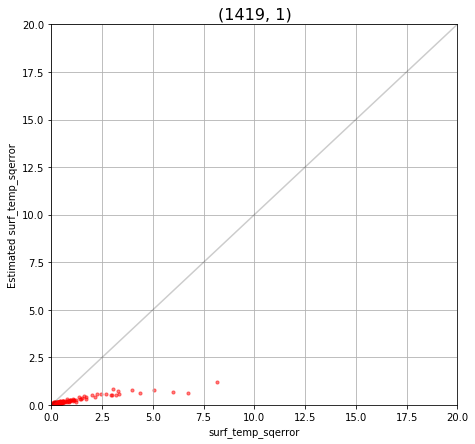

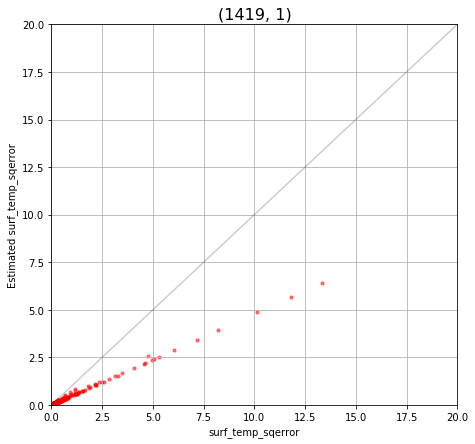

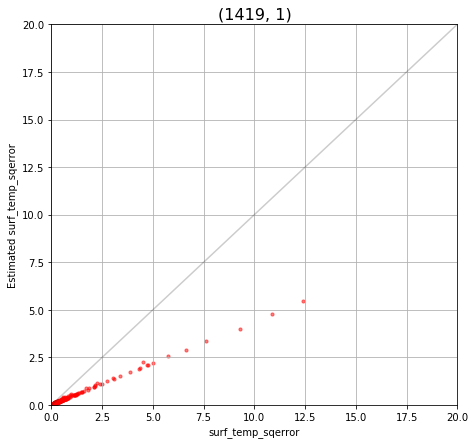

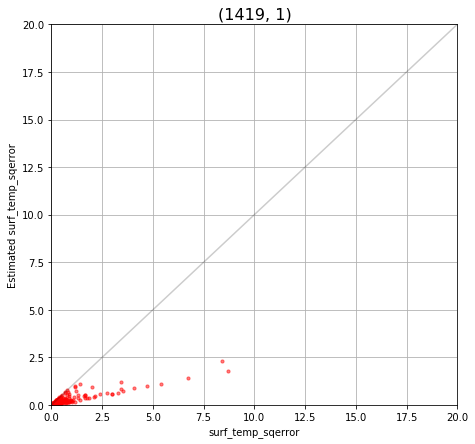

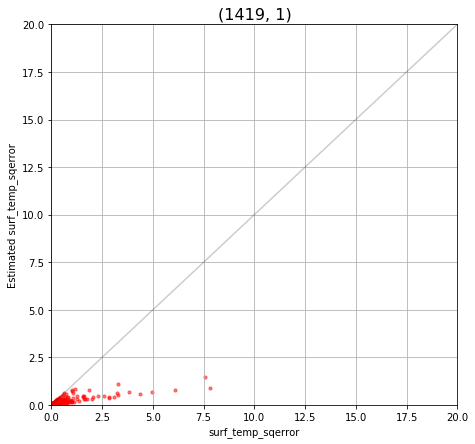

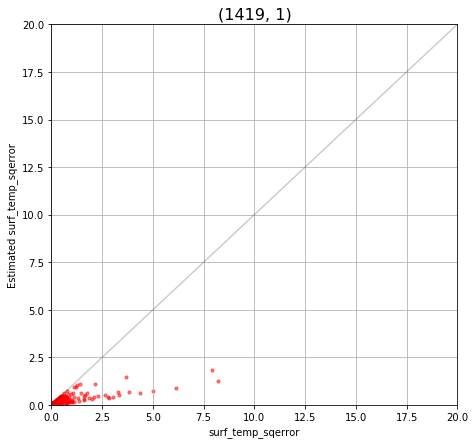

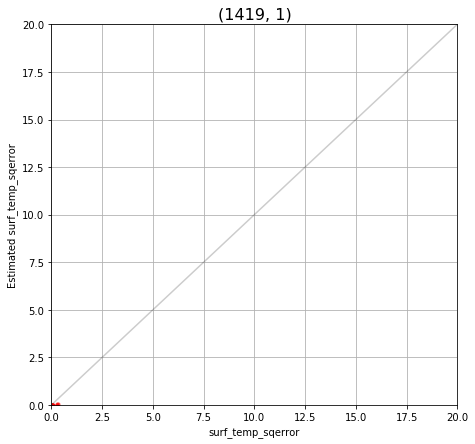

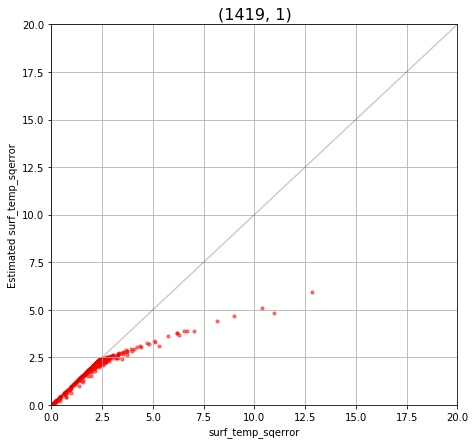

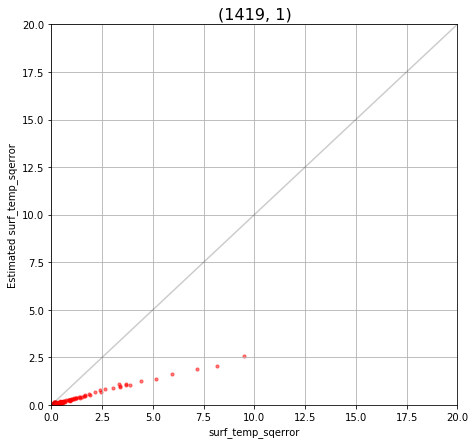

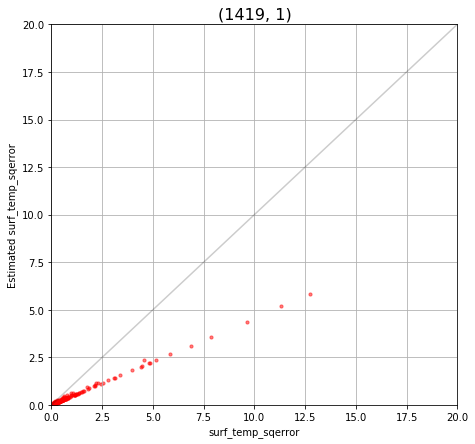

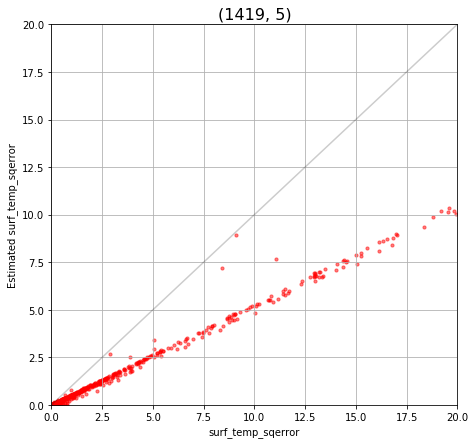

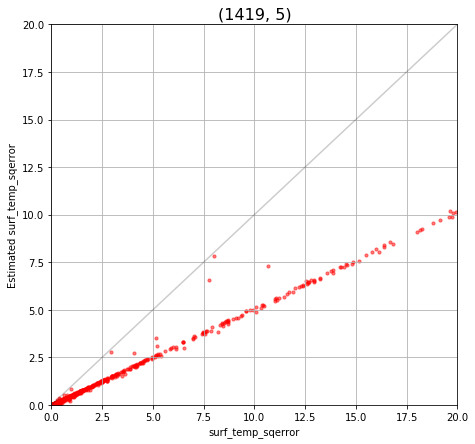

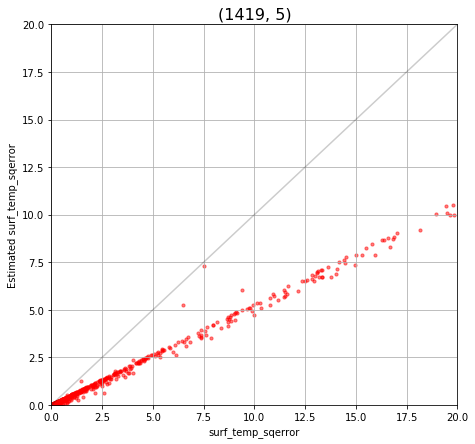

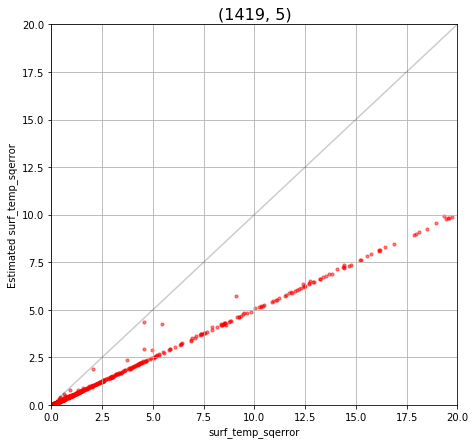

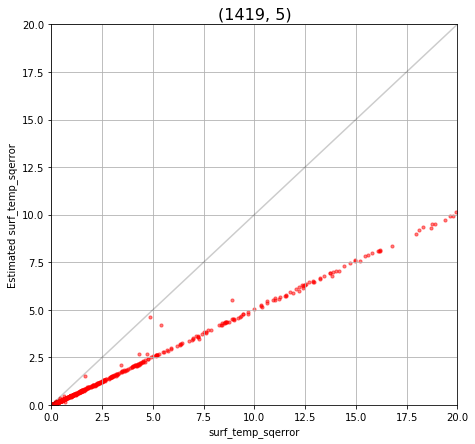

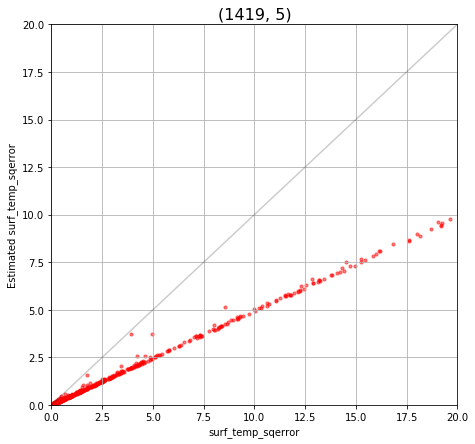

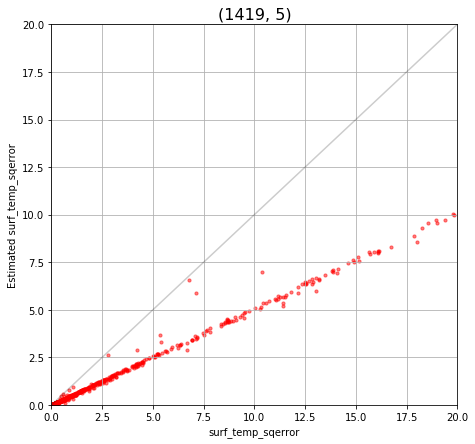

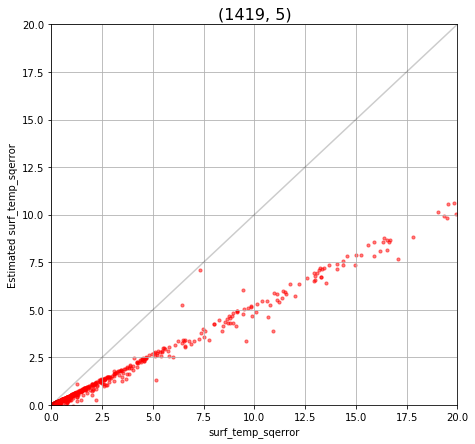

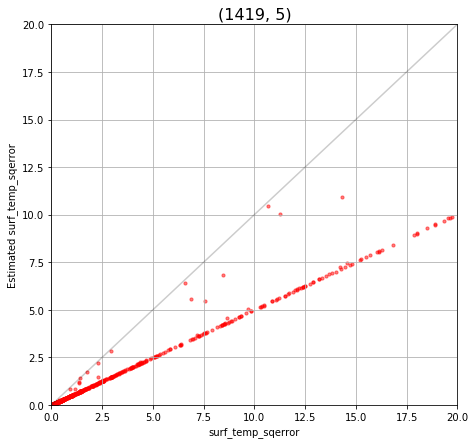

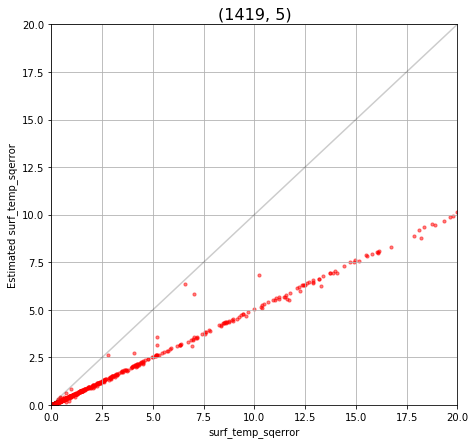

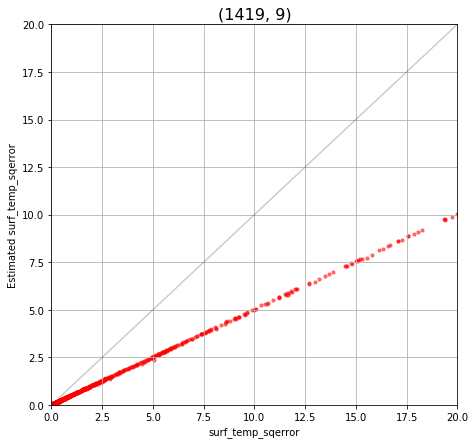

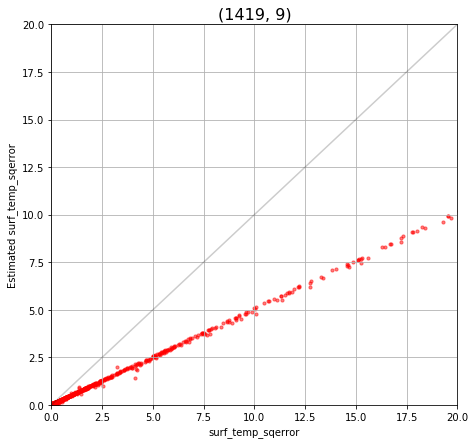

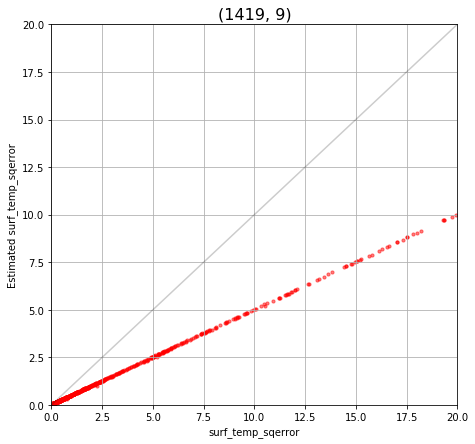

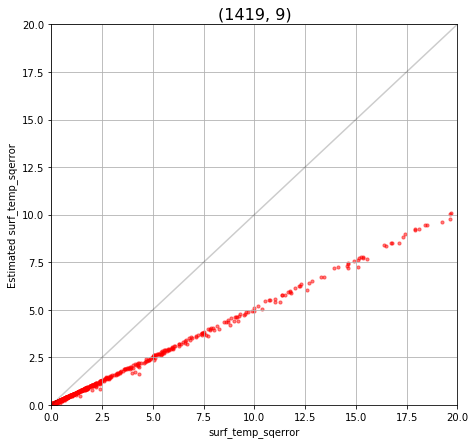

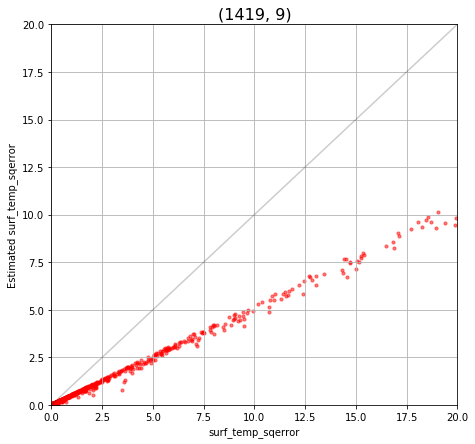

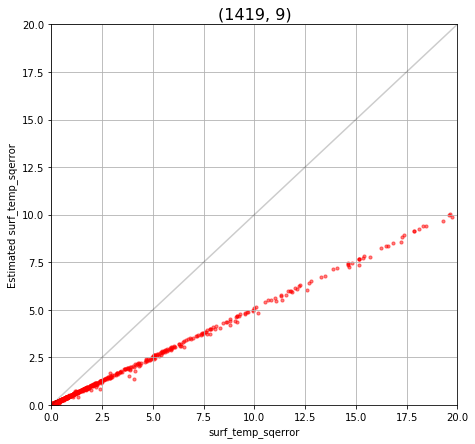

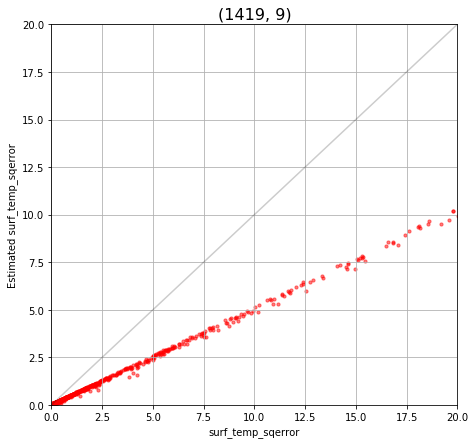

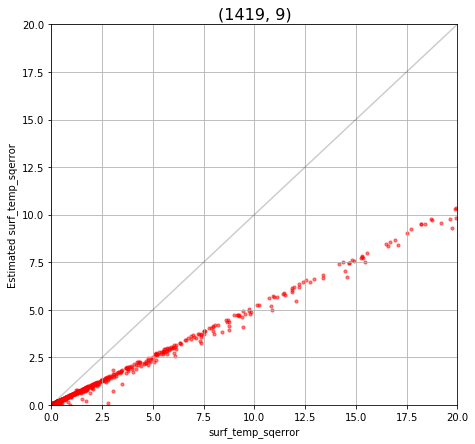

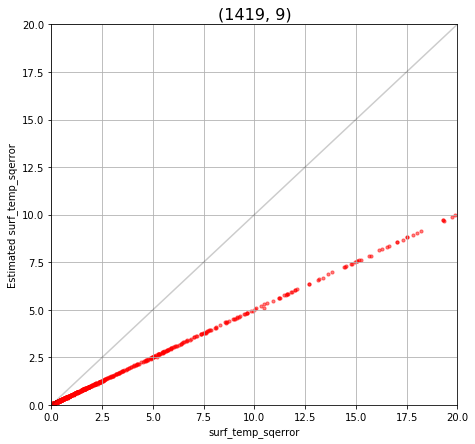

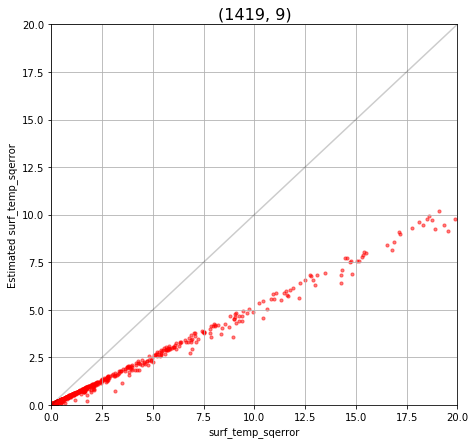

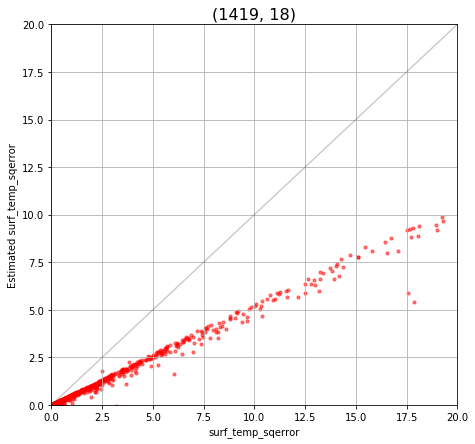

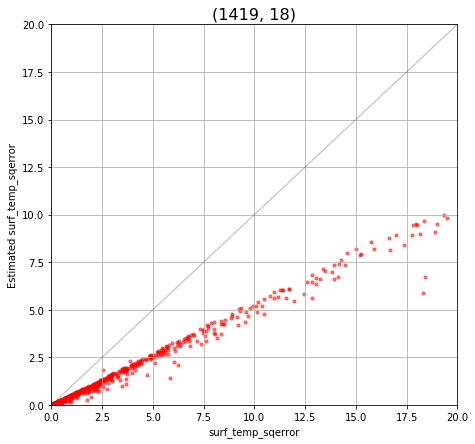

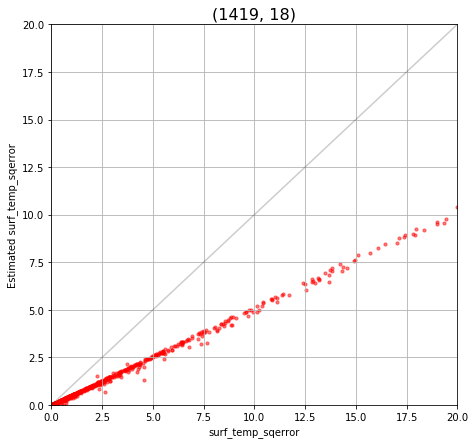

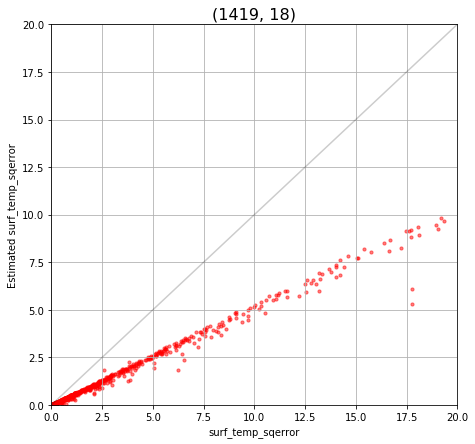

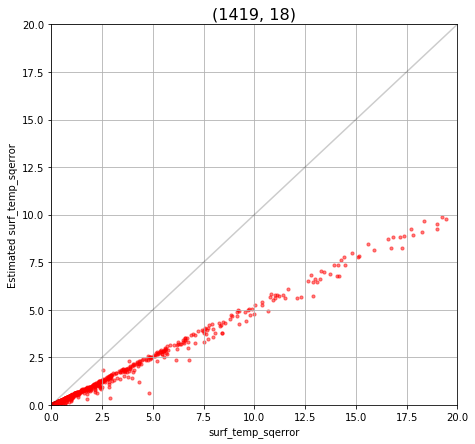

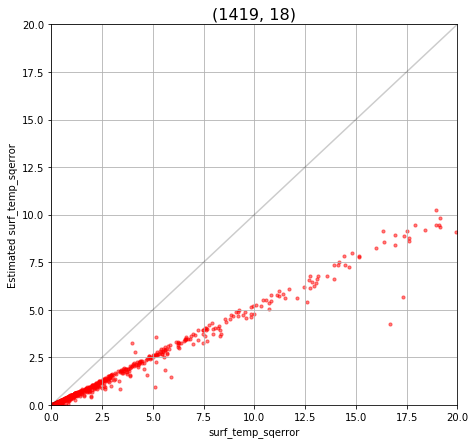

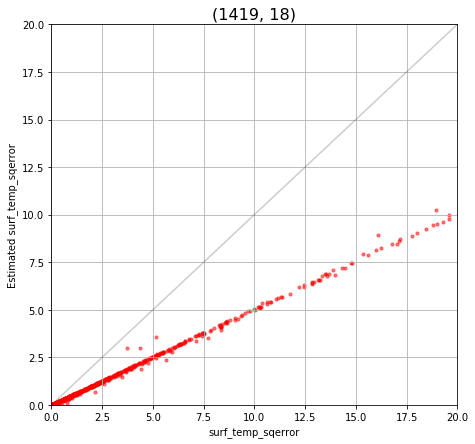

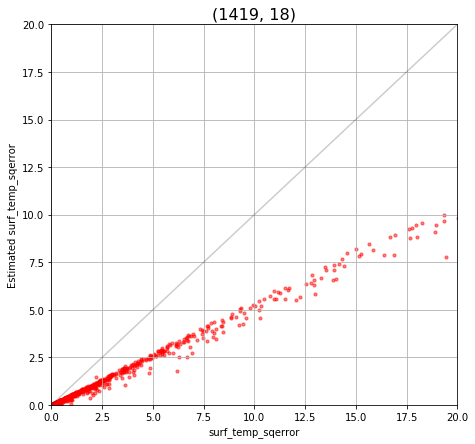

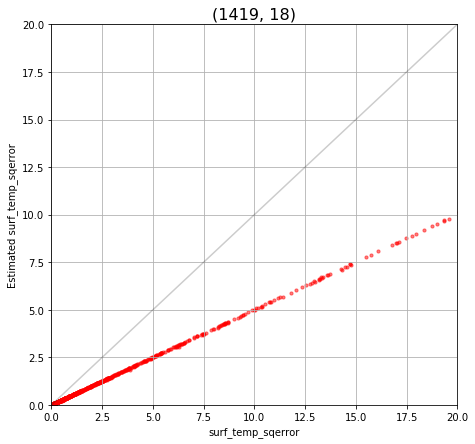

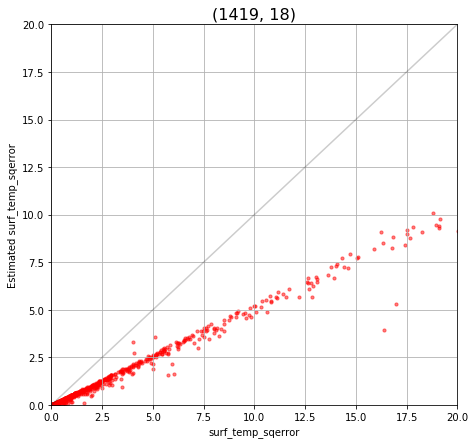

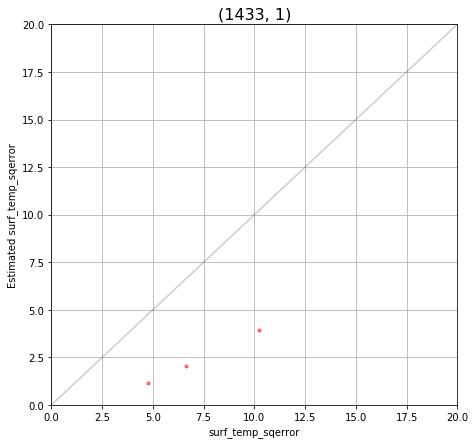

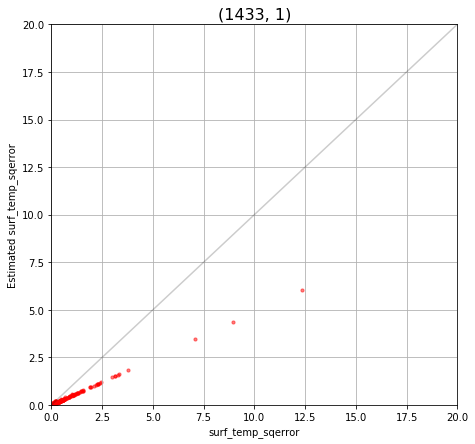

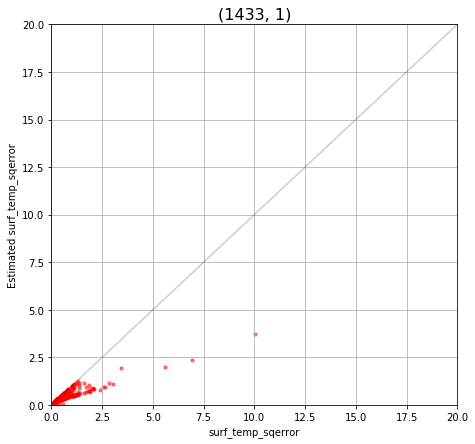

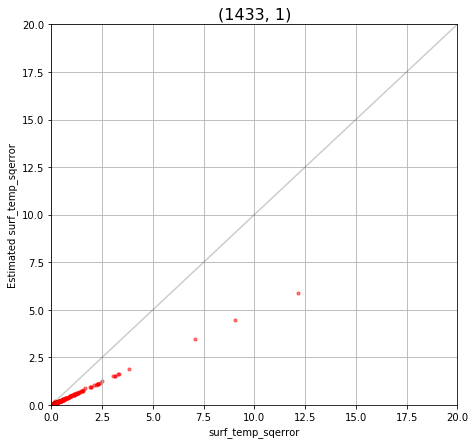

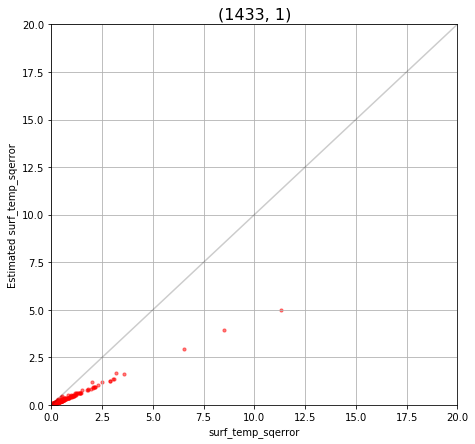

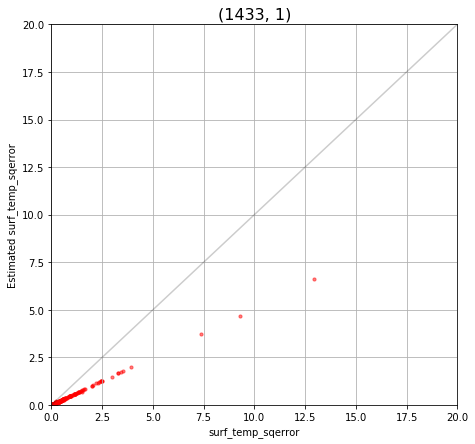

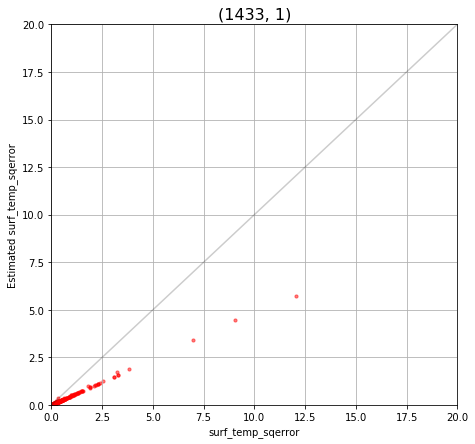

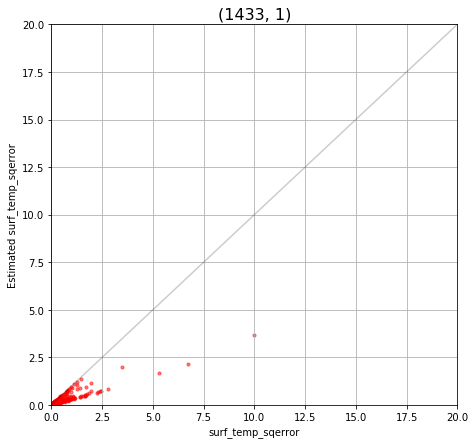

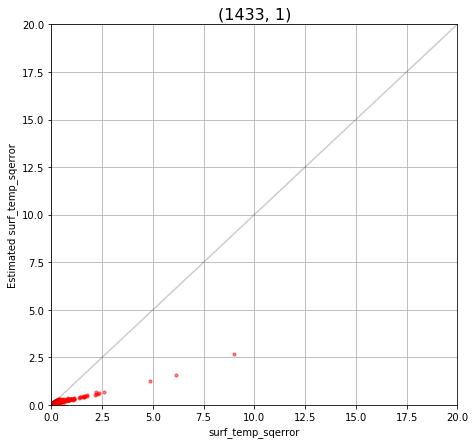

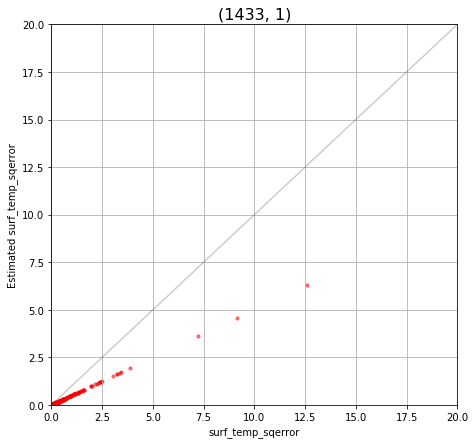

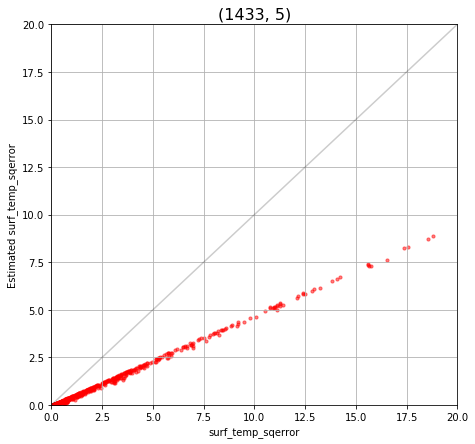

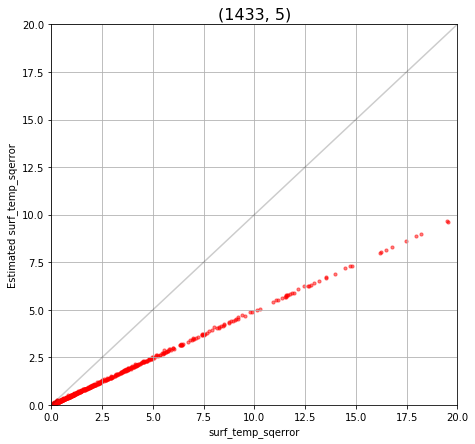

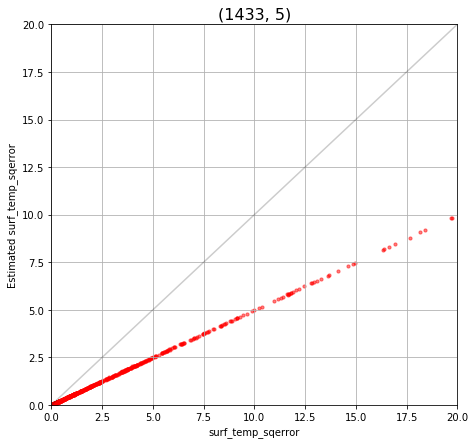

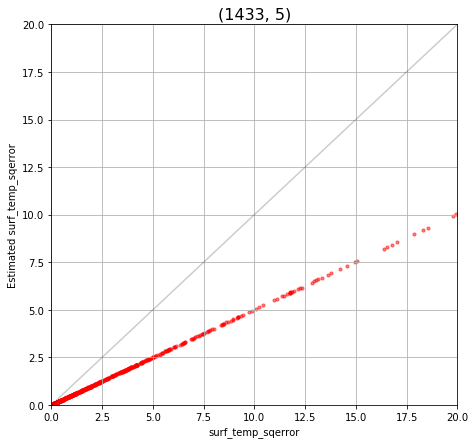

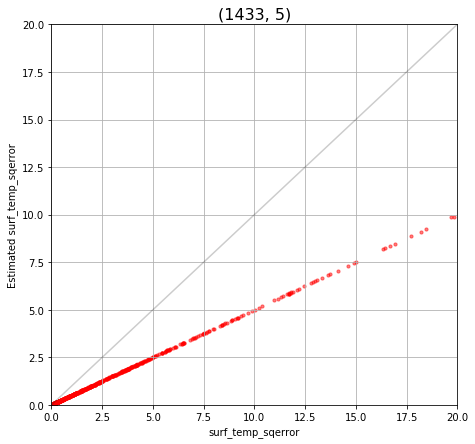

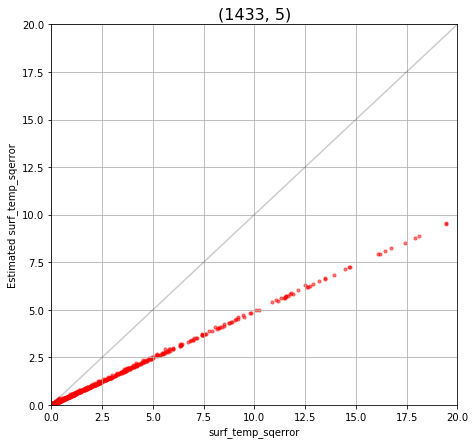

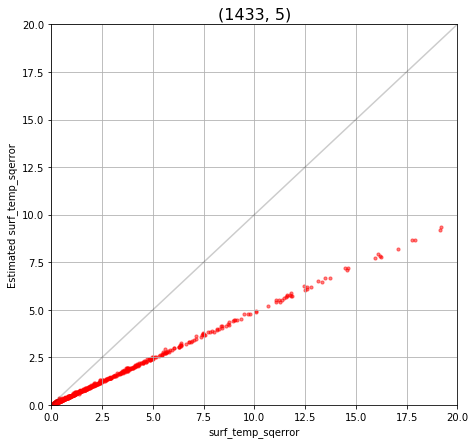

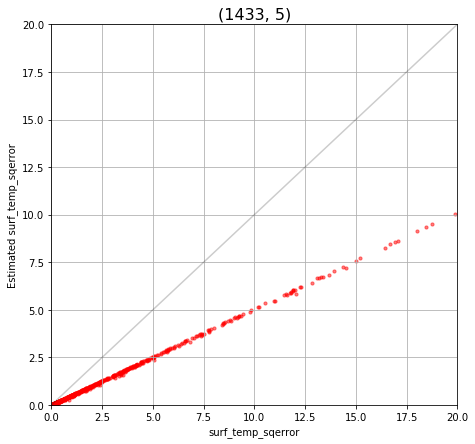

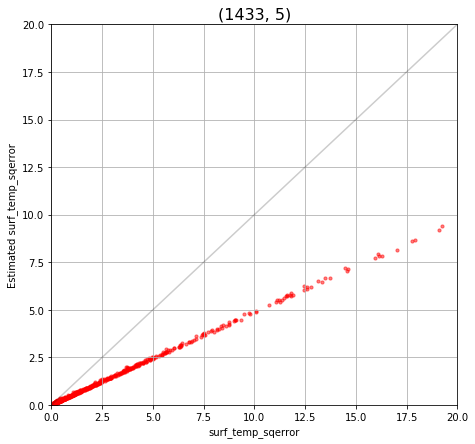

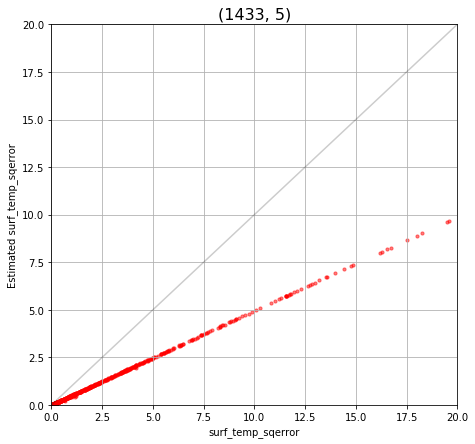

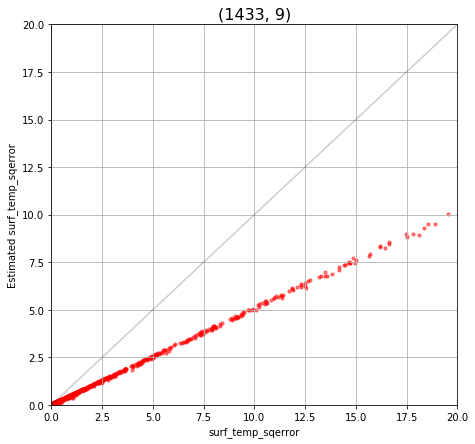

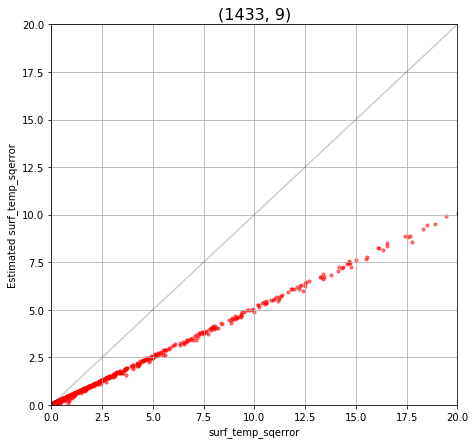

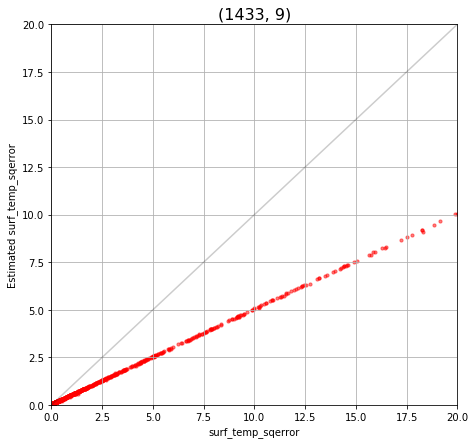

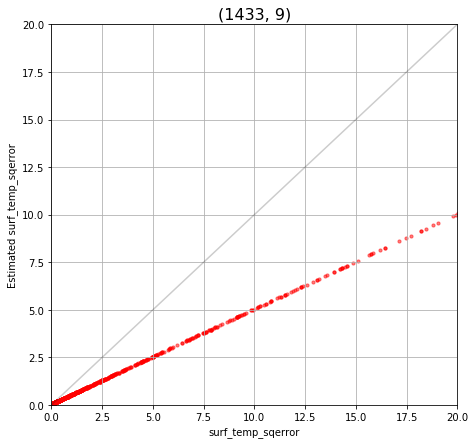

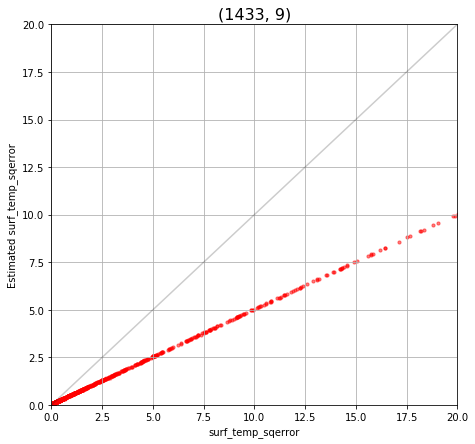

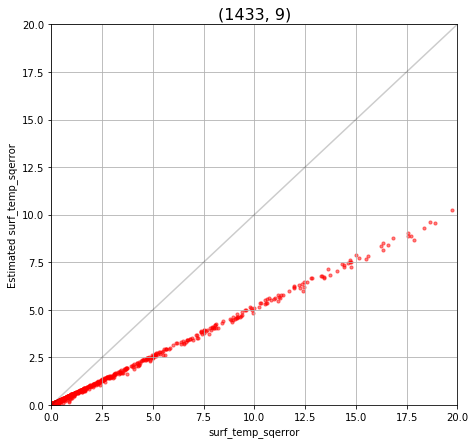

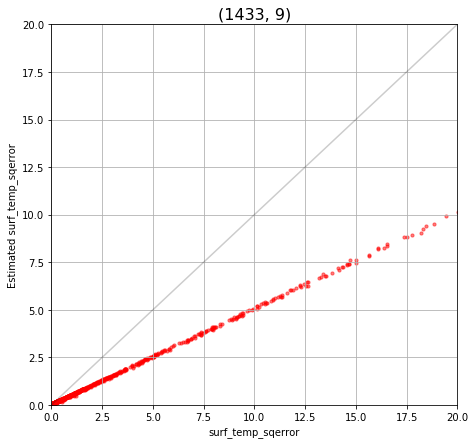

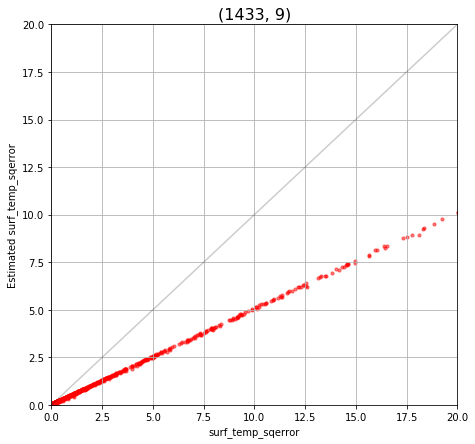

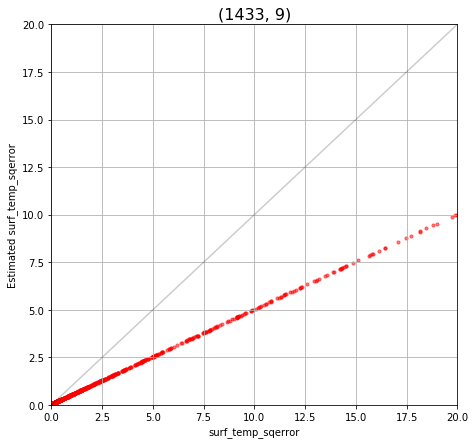

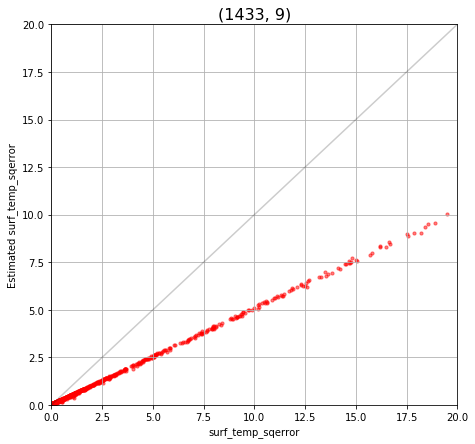

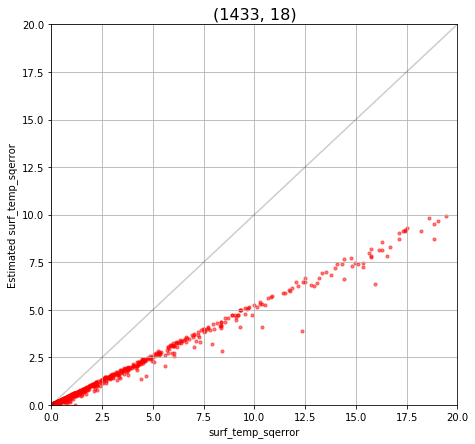

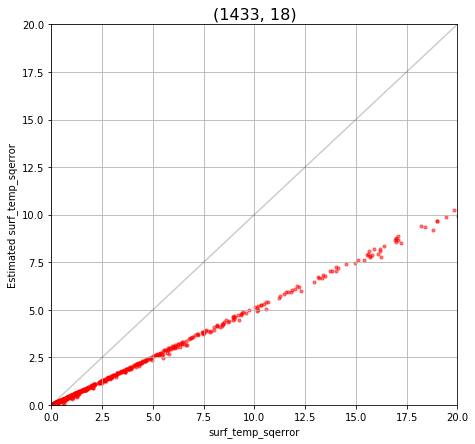

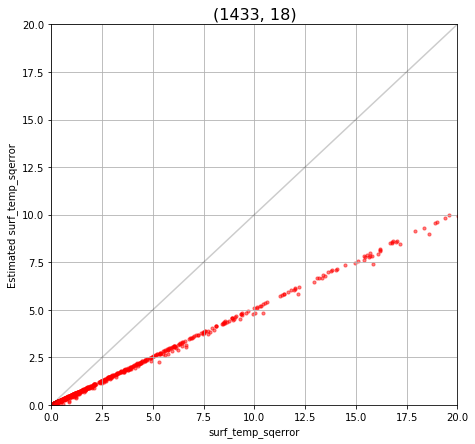

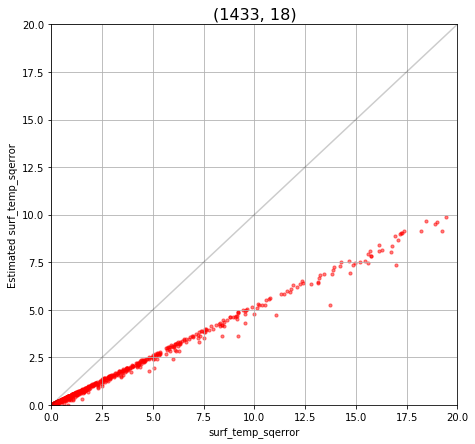

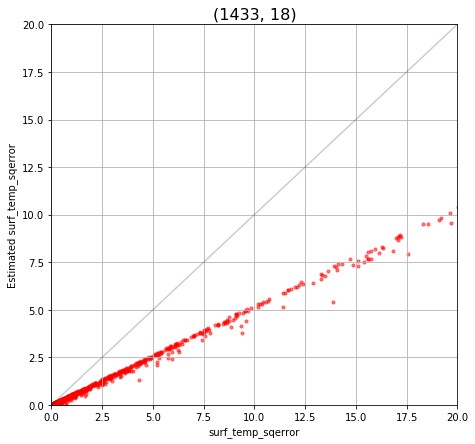

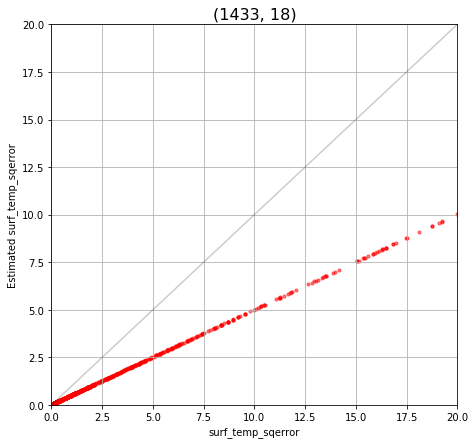

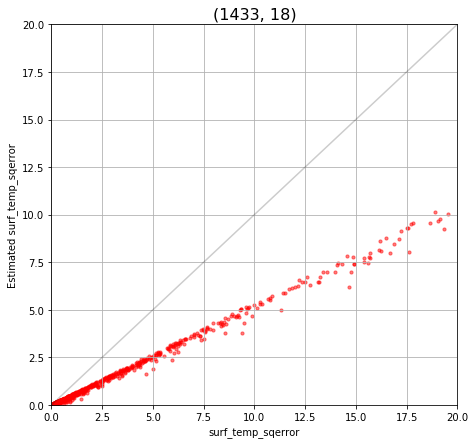

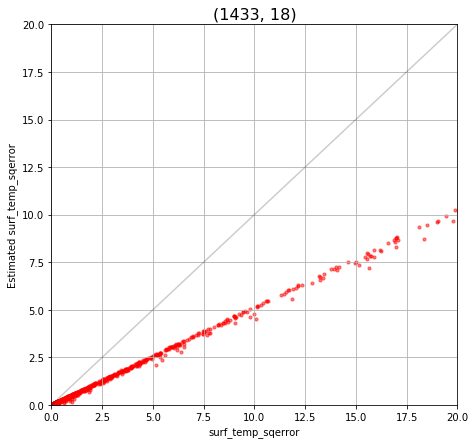

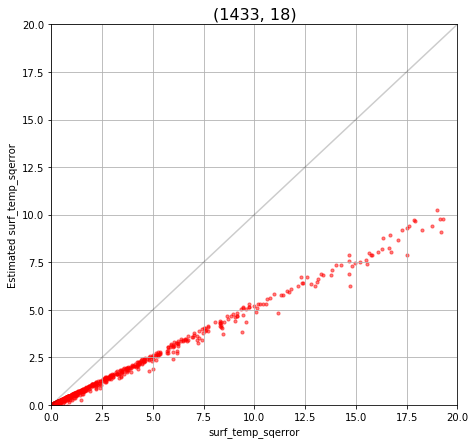

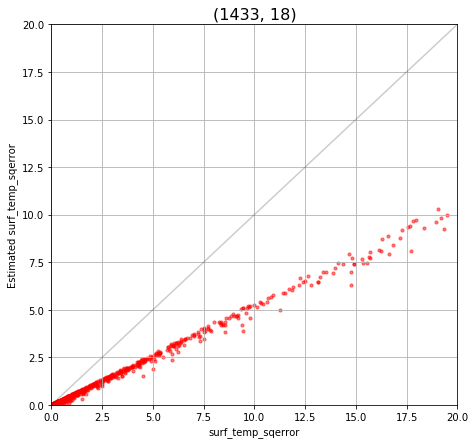

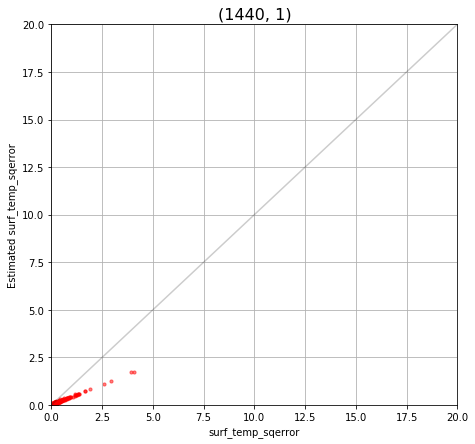

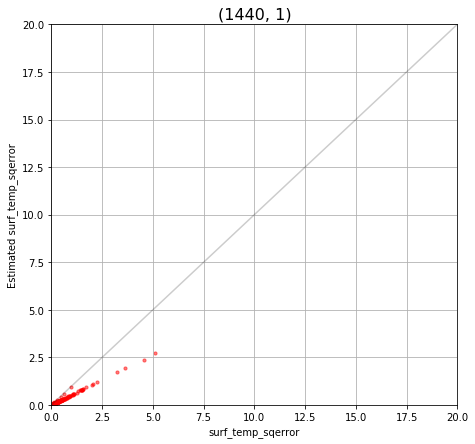

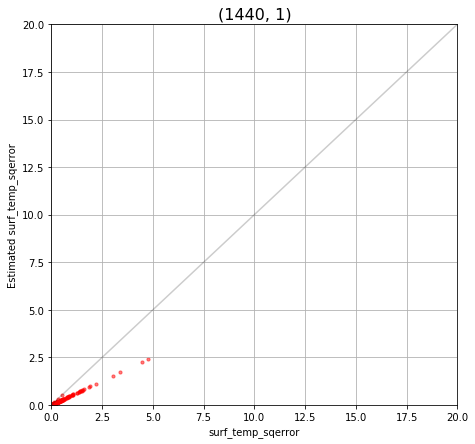

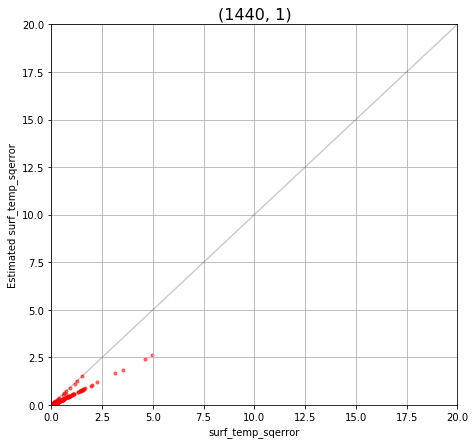

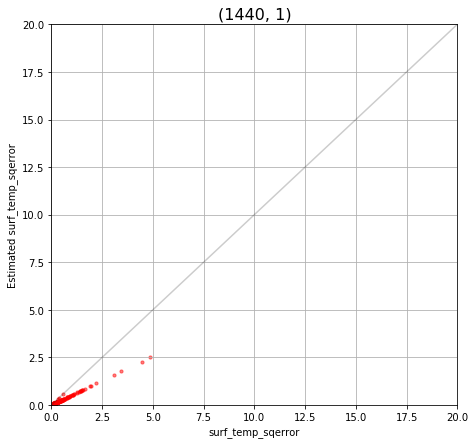

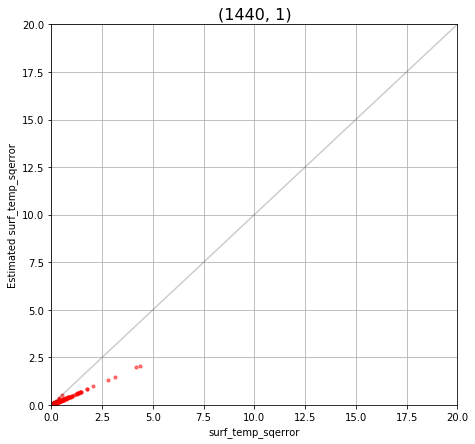

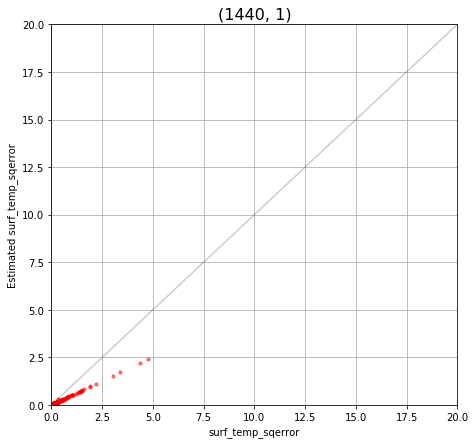

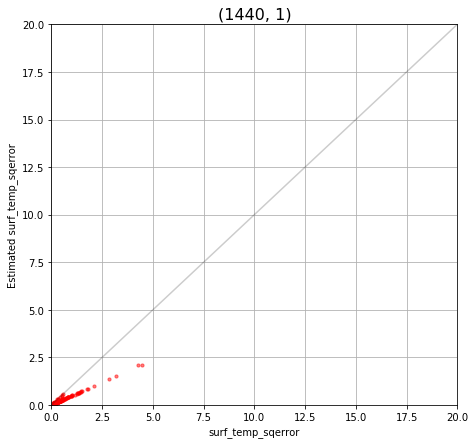

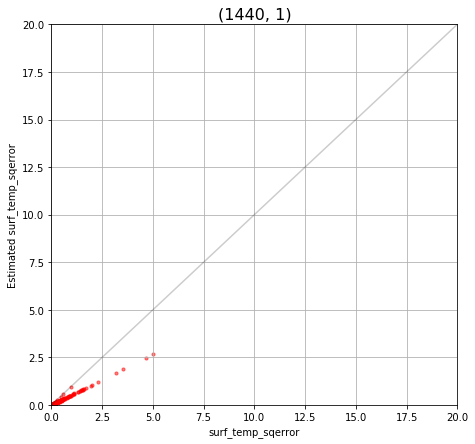

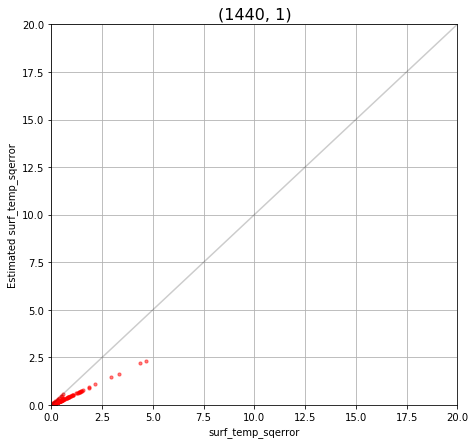

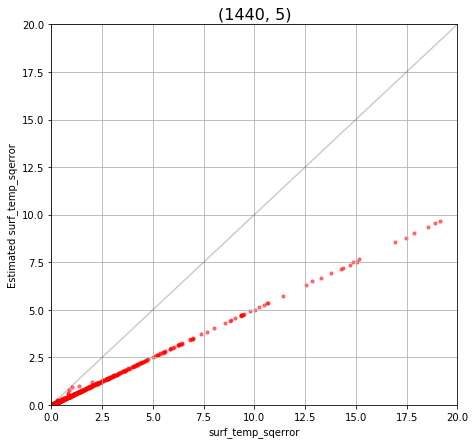

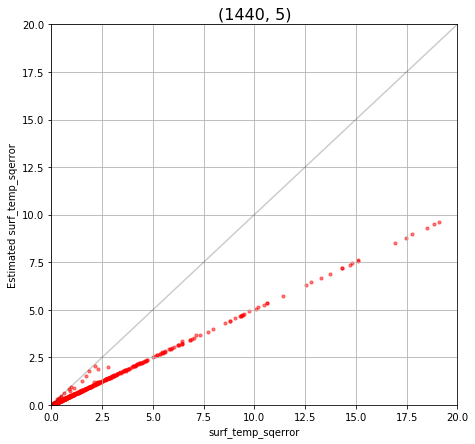

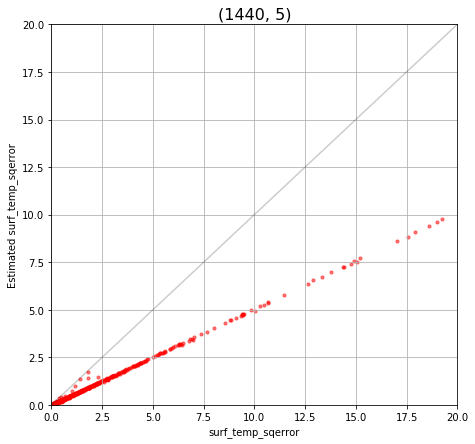

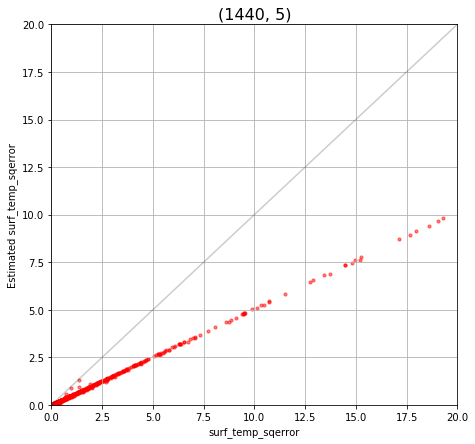

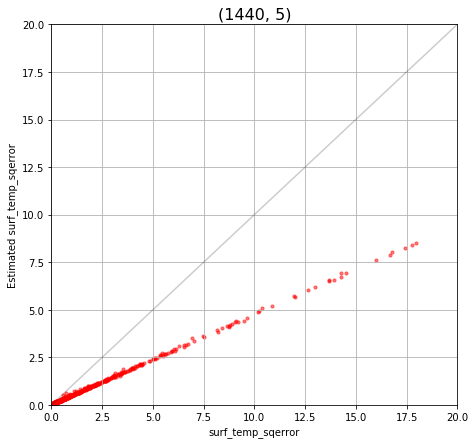

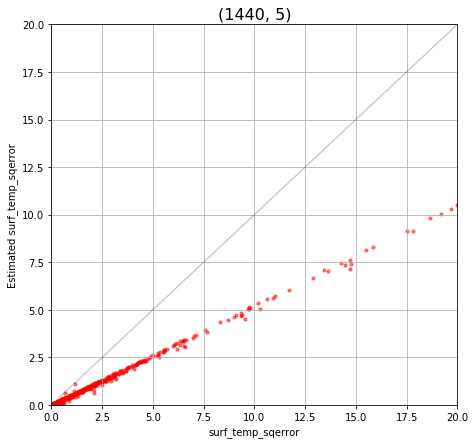

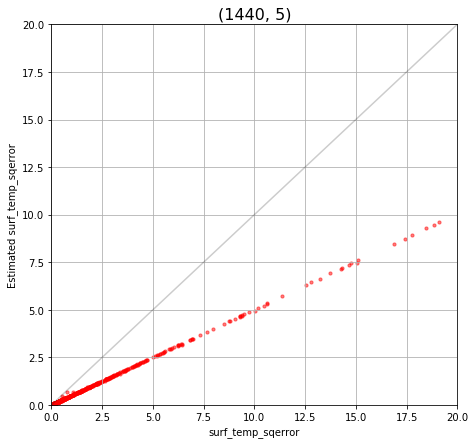

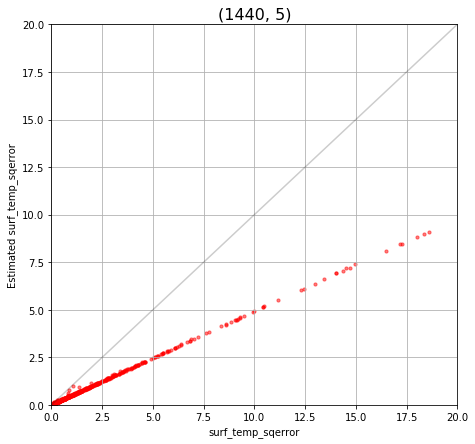

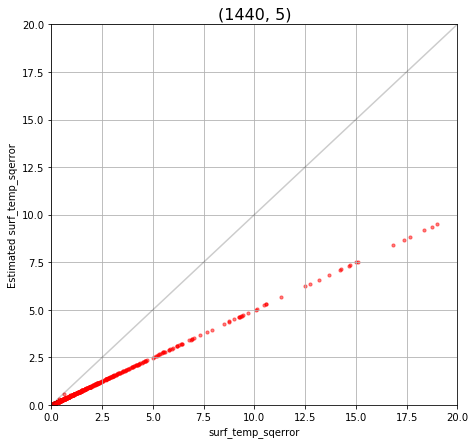

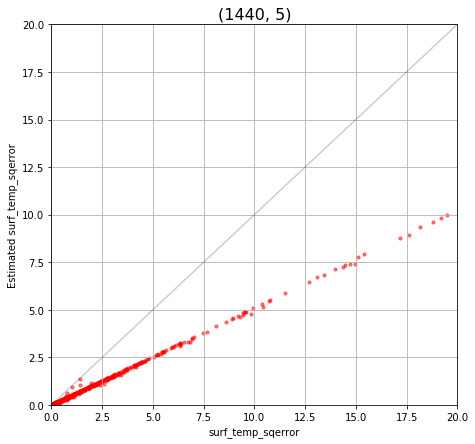

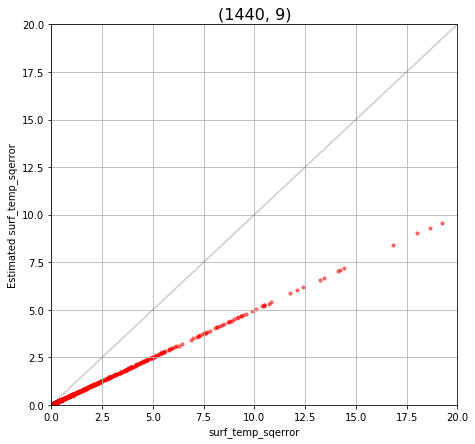

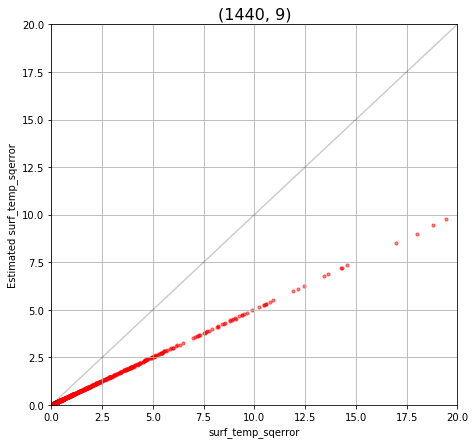

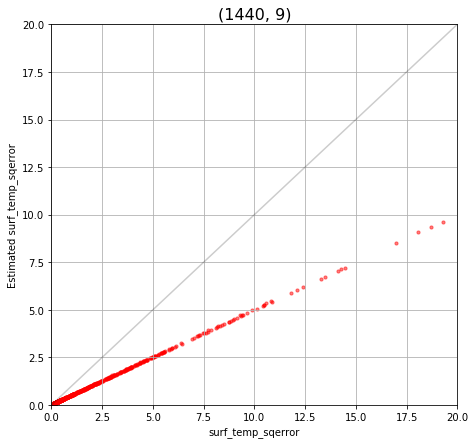

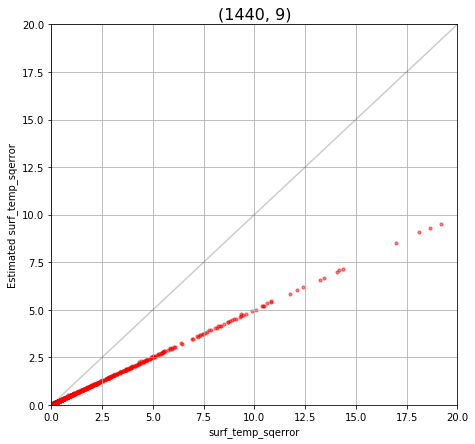

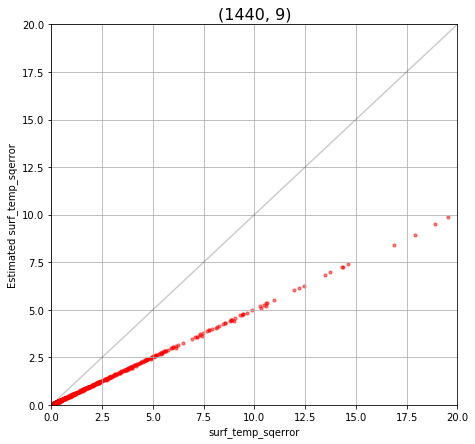

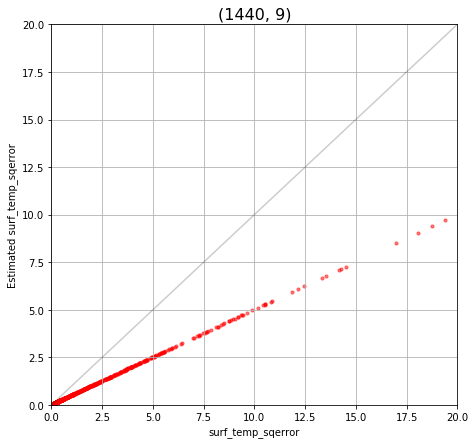

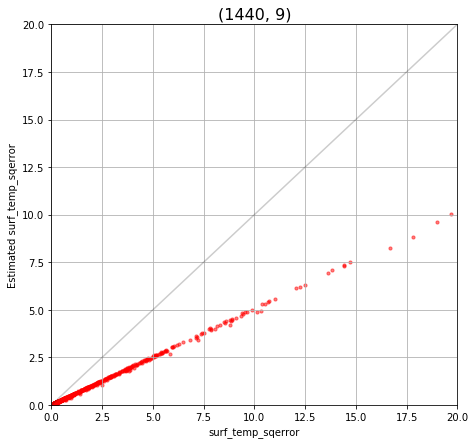

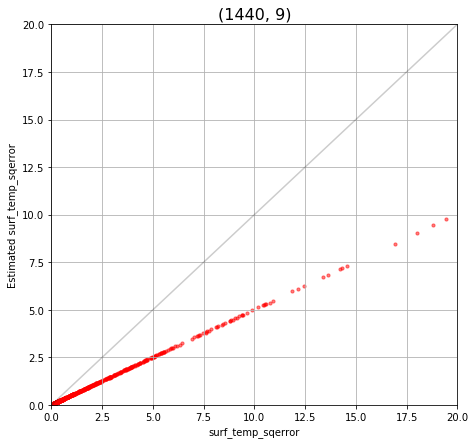

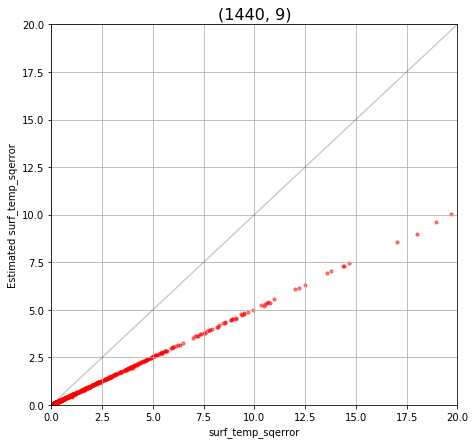

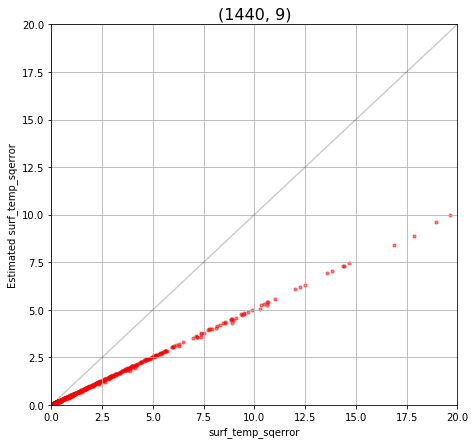

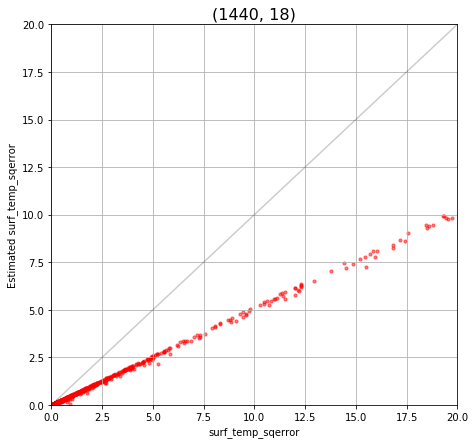

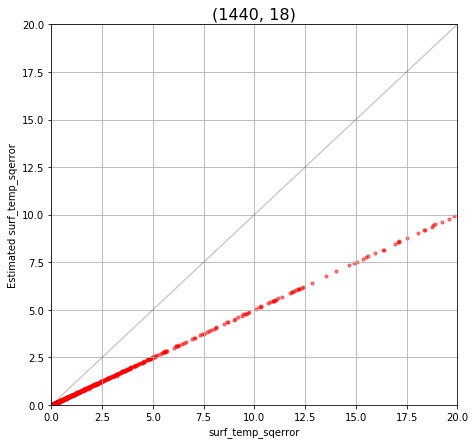

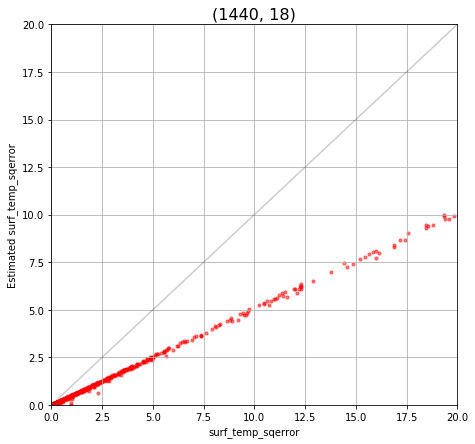

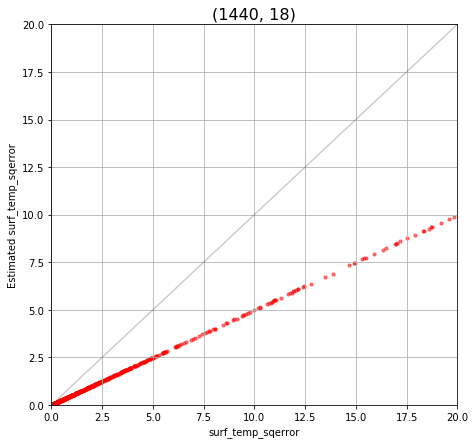

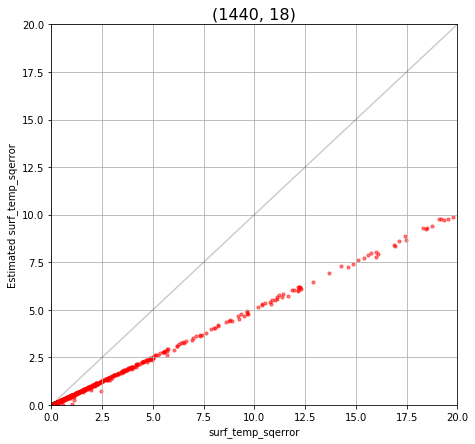

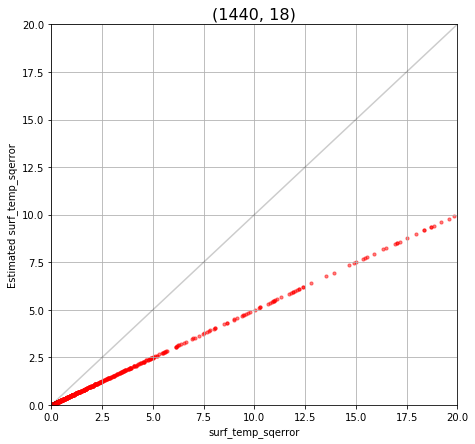

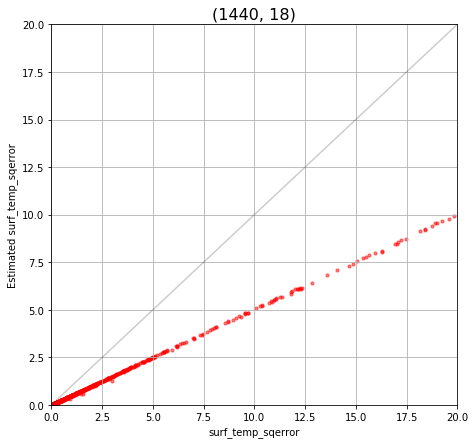

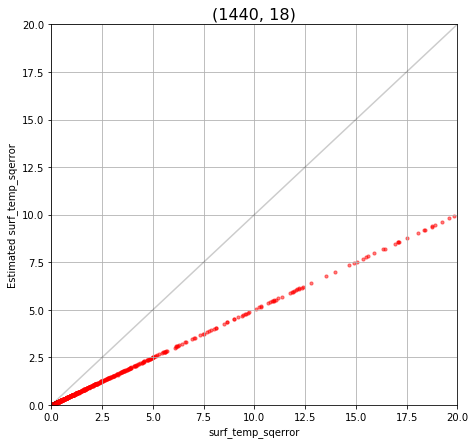

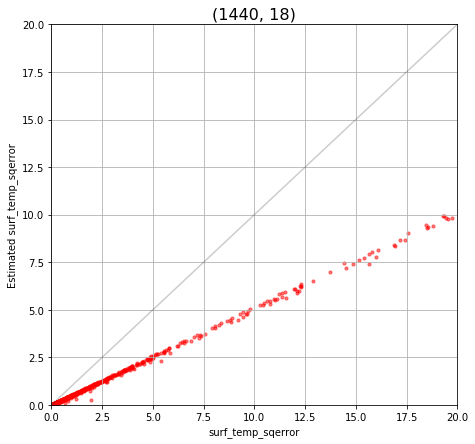

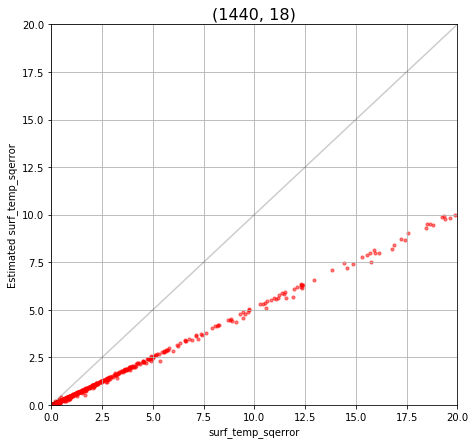

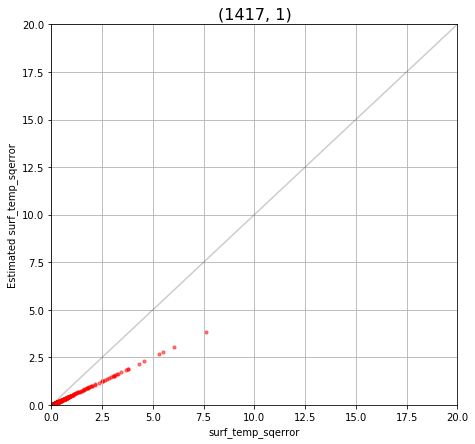

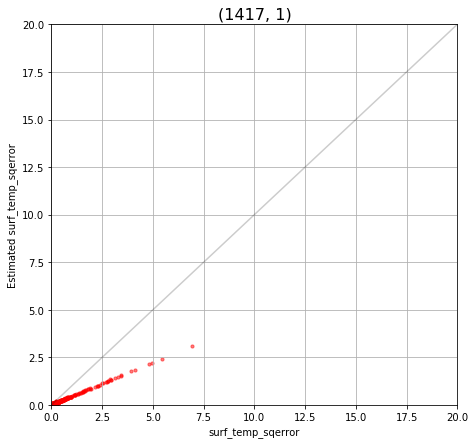

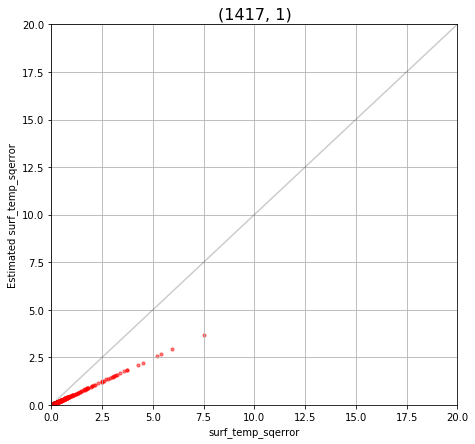

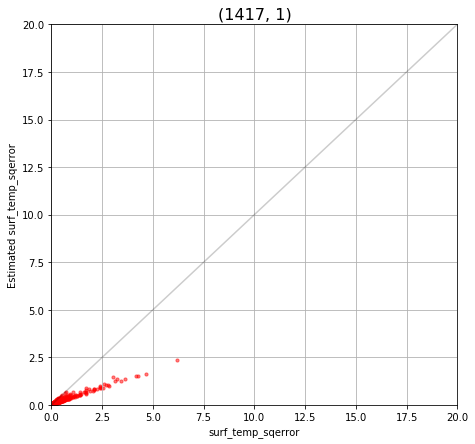

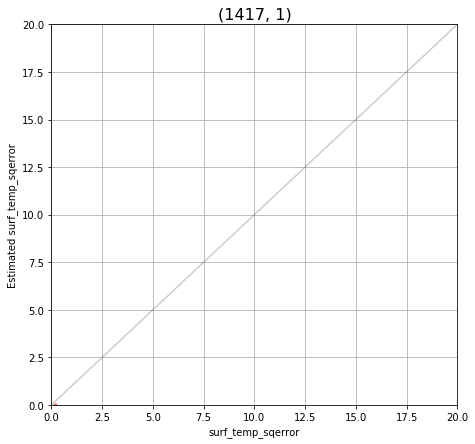

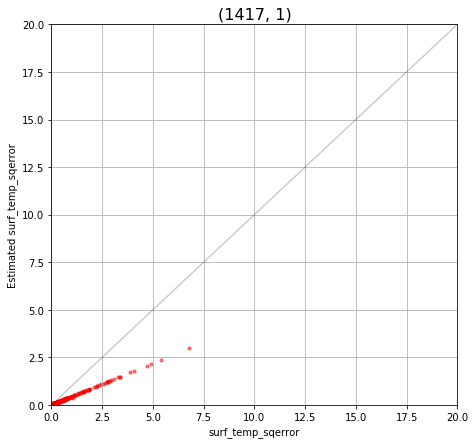

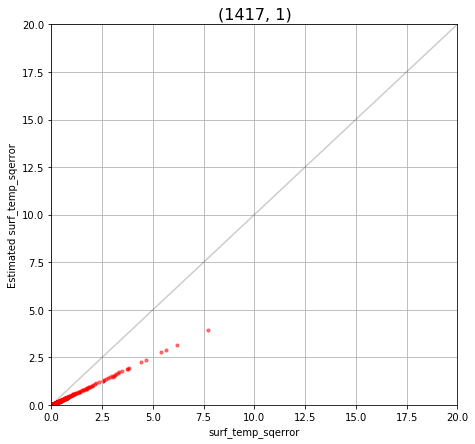

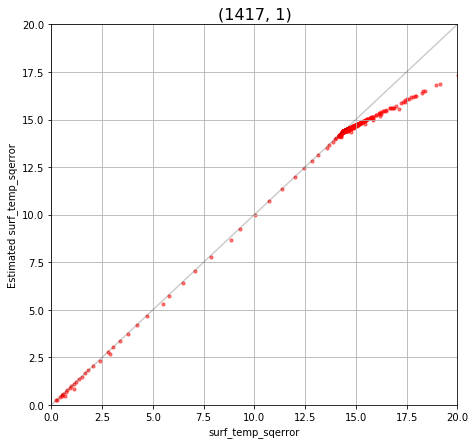

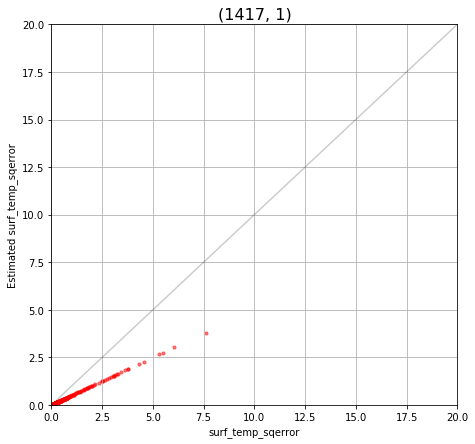

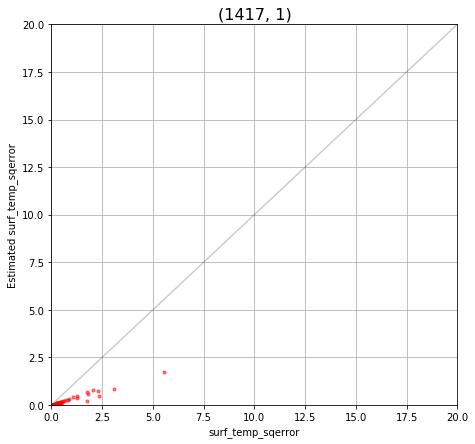

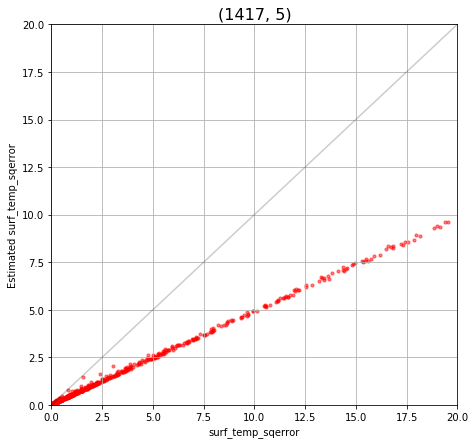

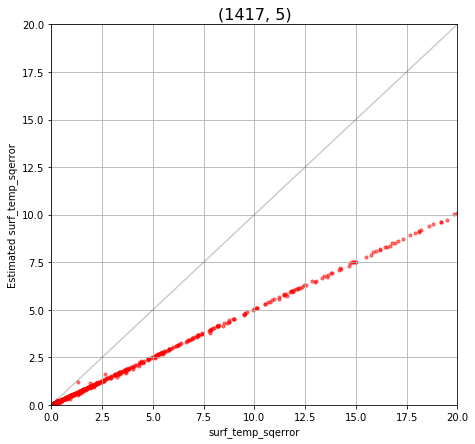

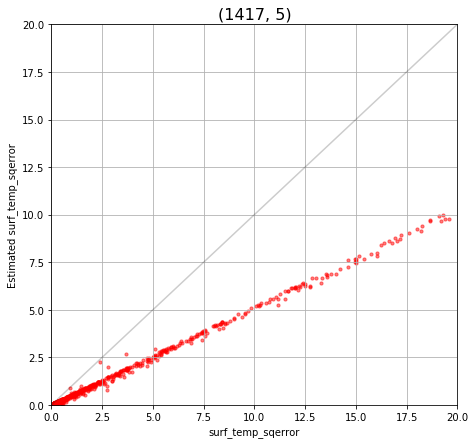

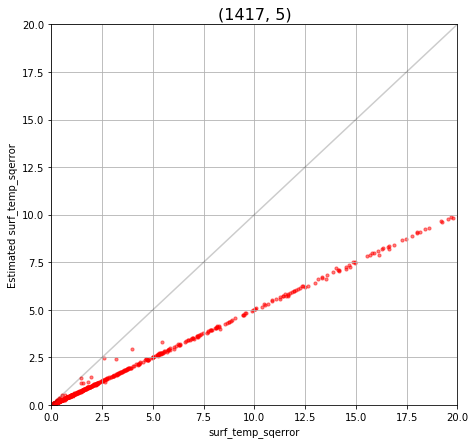

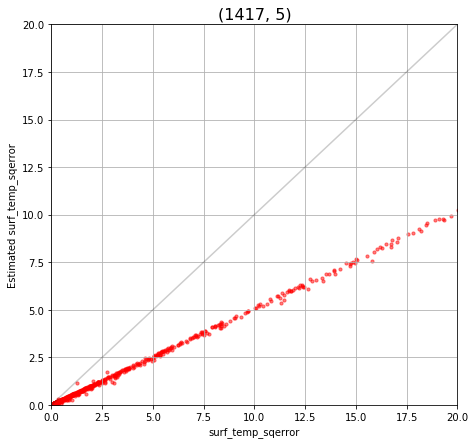

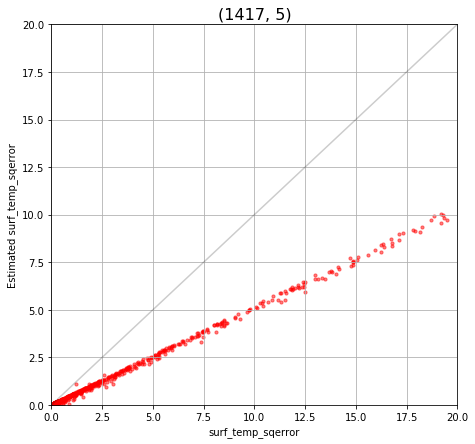

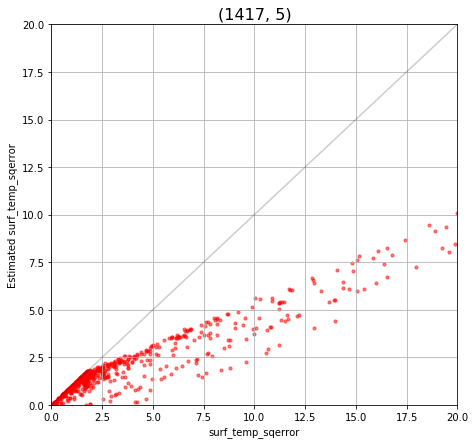

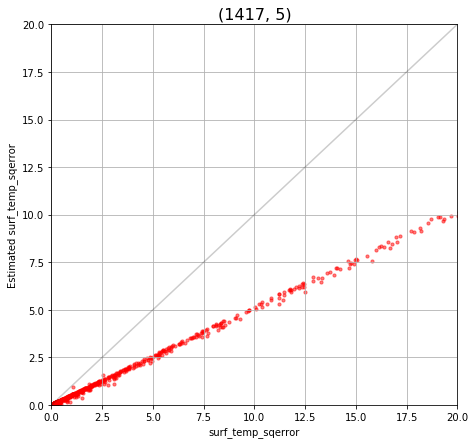

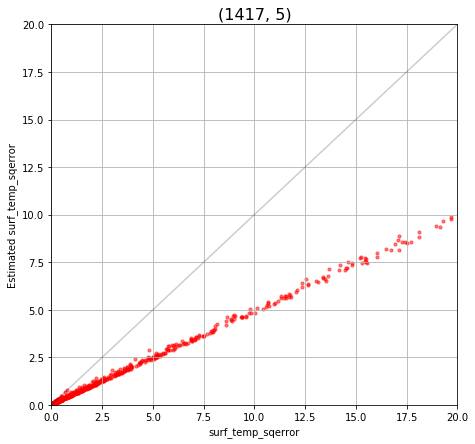

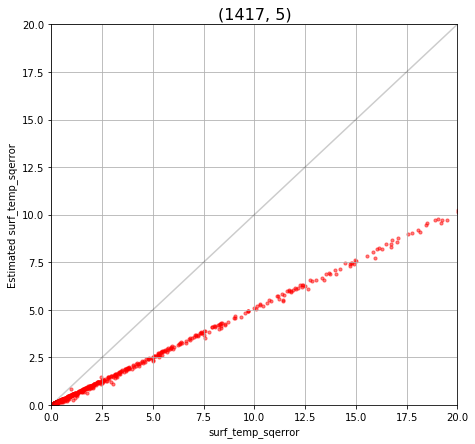

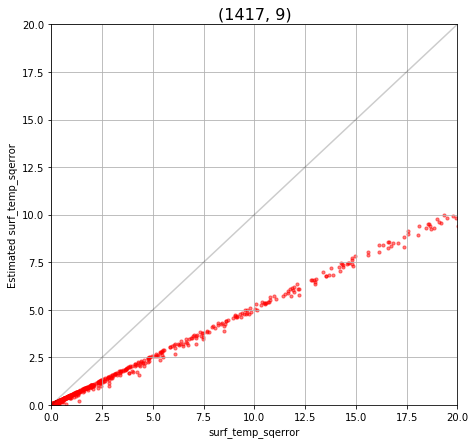

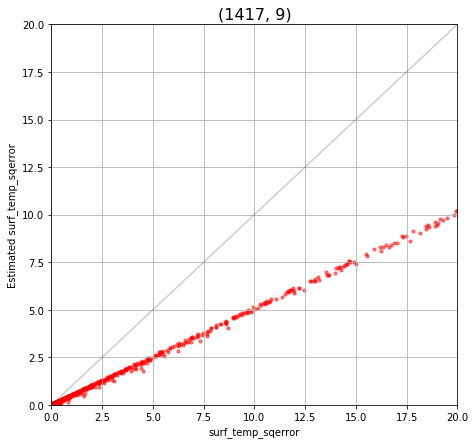

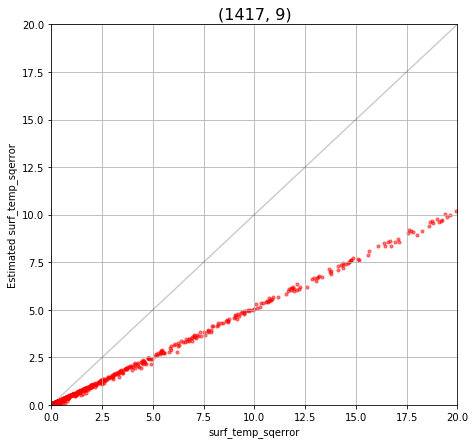

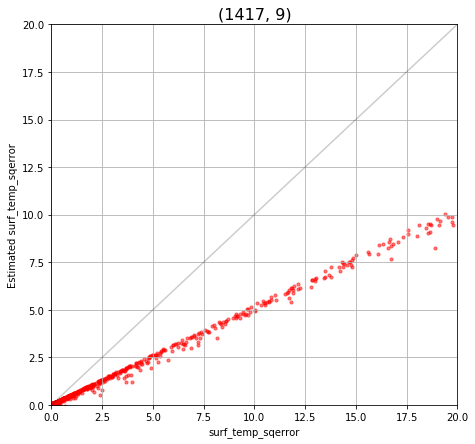

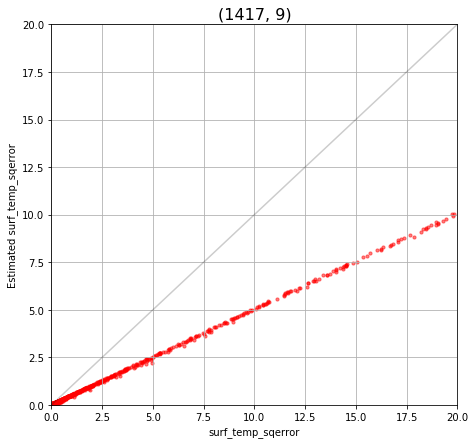

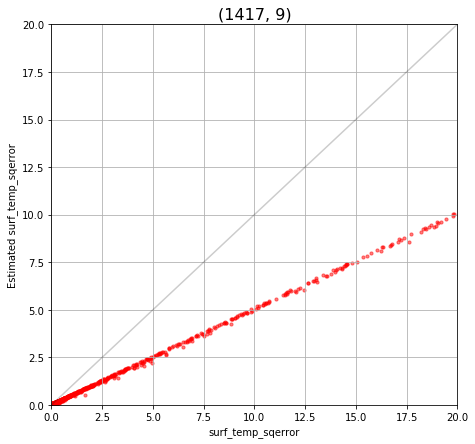

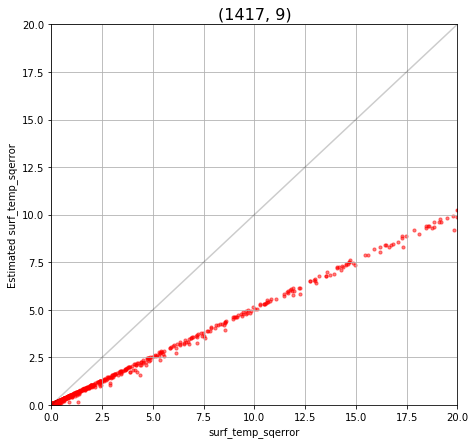

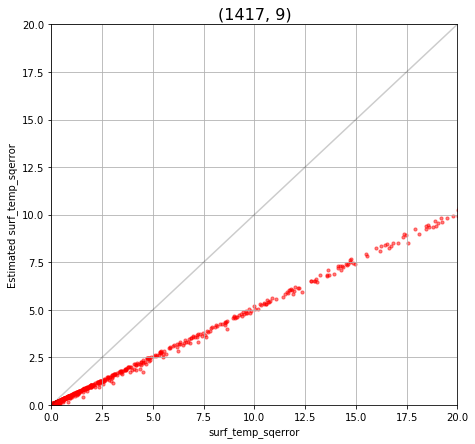

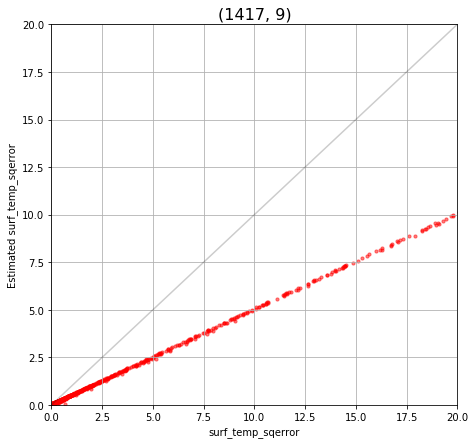

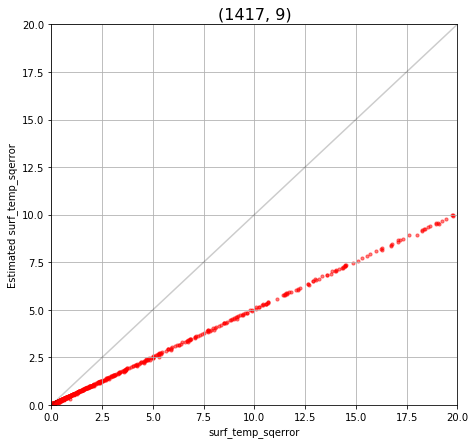

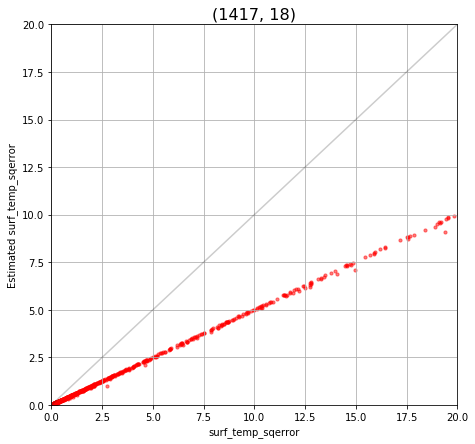

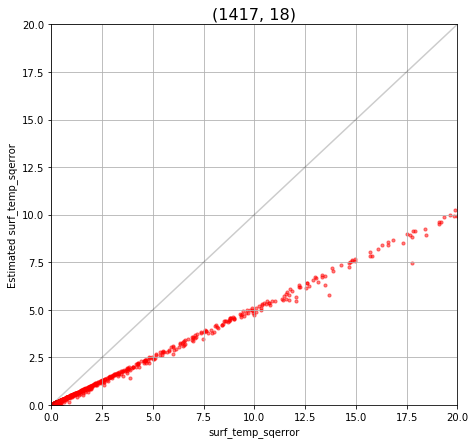

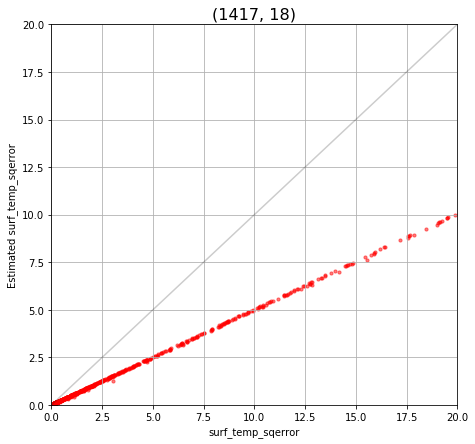

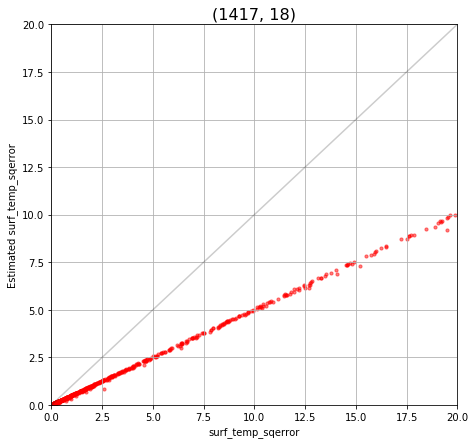

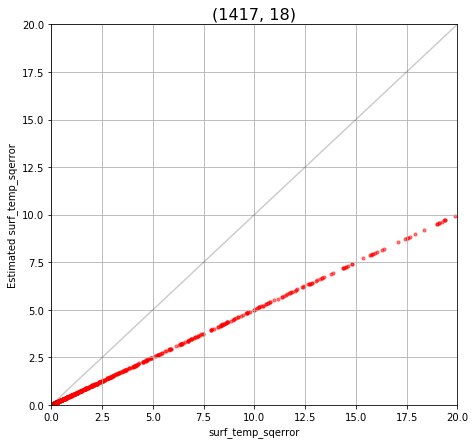

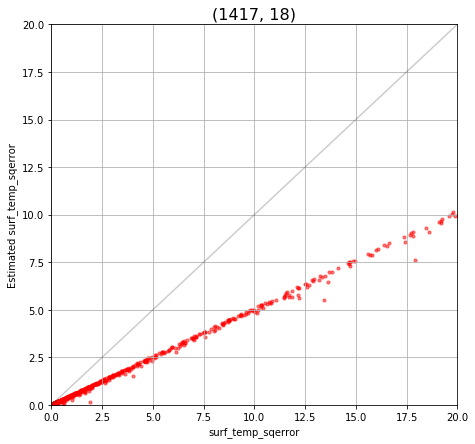

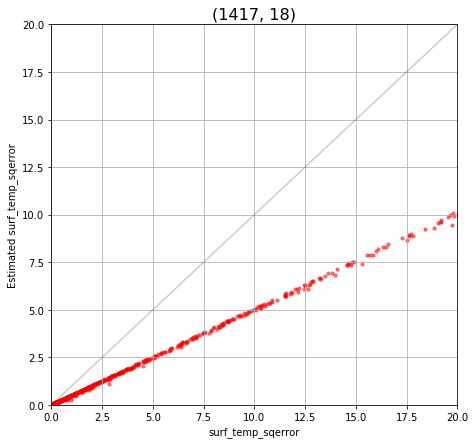

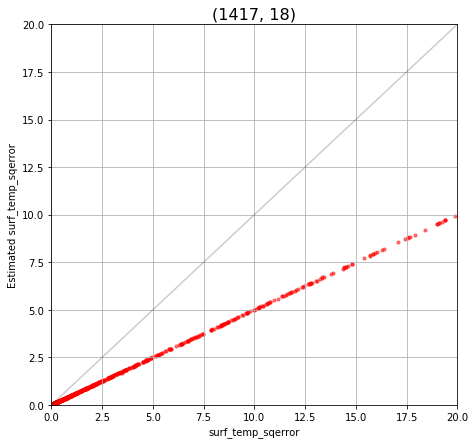

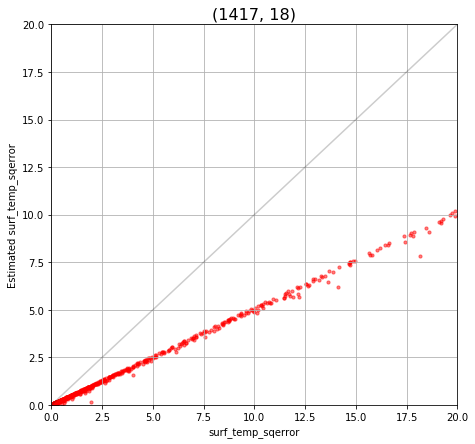

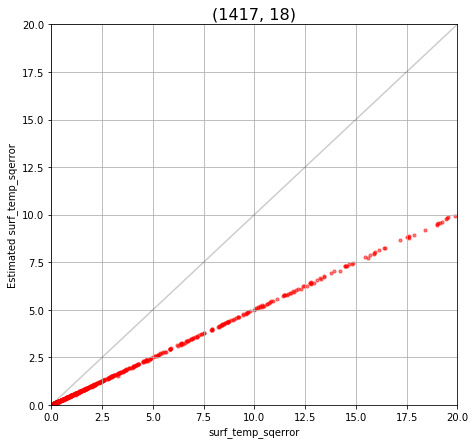

In [27]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

repeats = 10
batch_size = 1
features = 1
results = dict()
timesteps = 1

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        results[key] = experiment(repeats, df[key], batch_size, features, timesteps, key)    

In [28]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/rnn/data_{}.csv".format(str(key)))

    with open("results/rnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)